In [1]:
cd /home/c01muya/vae-disentanglement/disentanglement_lib_pl

/home/c01muya/vae-disentanglement/disentanglement_lib_pl


In [1]:
cd D:\\Saarbrucken\\EDA_Research\\vae-disentanglement\\disentanglement_lib_pl

D:\Saarbrucken\EDA_Research\vae-disentanglement\disentanglement_lib_pl


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns

import torch
import torchvision.utils as vutils
import torchvision.transforms.functional as T
from torch.utils.data import DataLoader
from torchvision import transforms

from bvae_experiment import BVAEExperiment
from common.data_loader import DSpritesDataset, ThreeShapesDataset, ContinumDataset
from common.notebook_utils import *
from common.utils import CenteredNorm
# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})
np.set_printoptions(suppress=True,precision=4)

In [19]:
def model_and_activations(current_device,  dataset, checkpoint_path, activation_type,
                          batch_size=64, beta=1.0, z_dim=10, l_dim=6, num_batches=1):
    
    activations, full_dataset, model = load_model_and_data_and_get_activations(
                        dset_name=dataset, dset_path='../datasets', 
                        batch_size=batch_size, z_dim=z_dim , beta=beta, 
                        checkpoint_path=checkpoint_path, current_device=current_device, 
                        activation_type=activation_type, seed=123,  batches=num_batches, l_zero_reg=False, l_dim=l_dim
        )

    data_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle = False,drop_last=True)

    return model, activations, data_loader

def check_correlated_dimensions(image_batch, vae_model, current_device, perturb_value=None, perturb_mode='fixed'):
    """
    Train a normal Beta-VAE network on the correlated data
    Once it has been trained, pass a batch of B examples and do the following:

    For each example X:
        Pass it thru network to get latent activations then
        For each latent dim l from 1 to L do:
            perturb unit l which gives an image X_l
            pass X_l again thru the network and record the perturbed mean \mu_l

    For each dimension see if passing the image again leads to a change in any dimension other than the perturbed one (correlation)

    Ideally, we expect only the unit associated with the originally perturned dimension to change.

    If changing unit m consistently results in changes in unit n then we conclude that those two dimensions are correlated.

    We can then introduce a layer before that and connect these two dims to a unit in prev layer.
    """

    
    with torch.no_grad():
        
        sq_diff_batch = []
        fwd_pass_results = vae_model.model.forward(image_batch, current_device=current_device)
        x_recon_orig, mu_orig = fwd_pass_results['x_recon'], fwd_pass_results['mu'] 

        # for each example X, perturb unit l=1 to L 
        for mu in mu_orig:
            # (dim(mu), mu)
            mus_perturbed = _generate_perturbed_copies(mu, mode=perturb_mode,fixed_val=perturb_value)
            
            # generate and image from these perturbed means
            # (dim(mu), X.shape)
            x_recons_perturbed = vae_model.model.decode(mus_perturbed, current_device=current_device)
            # pass images again and compare with mu_perturbed
            # (dim(mu), mu)
            mus_perturbed_recon, _ = vae_model.model.encode(x_recons_perturbed, current_device=current_device)

            sq_diff = (mus_perturbed_recon - mus_perturbed).pow(2)
            sq_diff_batch.append((sq_diff, mus_perturbed_recon, mus_perturbed, x_recons_perturbed))

        return sq_diff_batch

def _generate_perturbed_copies(vector, dims_to_perturb=None, mode = 'fixed', fixed_val=None):
    """
    Assumes that vector is of shape (vector_dim, )
    Returns (vector_dim, vector_dim) shaped vector where in (i, vector_dim)
    mode: 'fixed','relative-min','relative-max' 
    """

    perturbed_copies = []

    for d in range(vector.shape[0]):
        if dims_to_perturb is not None and d not in dims_to_perturb:
                continue
        
        vector_d = vector.clone()
        lim = vector_d[d] / 2
        min_val, max_val = vector_d[d] - lim, vector_d[d] + lim + 0.1
        
        if mode == 'relative-max':    
            vector_d[d] = vector_d[d] + max_val
        
        if mode == 'relative-min':
            vector_d[d] = vector_d[d] - min_val
        
        if mode == 'fixed':
            vector_d[d] = vector_d[d] + fixed_val

        perturbed_copies.append(vector_d)

    return torch.stack(perturbed_copies, dim=0)

# Correlation 0.2 Beta 2

In [3]:
current_device = torch.device("cuda:3")
dataset='dsprites_full'
checkpoint_path="../train-logs/jscmodel/epoch=25-step=299520.ckpt"

model_and_activations(current_device,  dataset, checkpoint_path)

Experiment class: cpu
Model class: cpu
Loaded 737280 images


  0%|▏                                                                                                                                                                                                   | 10/10368 [00:01<24:24,  7.07it/s]


In [4]:
img, labels = next(dsprites_full_loader.__iter__())


In [54]:
diffs = check_correlated_dimensions(img.to(current_device), model_dsprites_full, current_device)


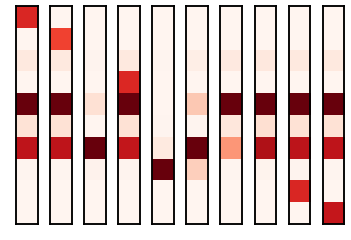

In [48]:
visualize_change(diffs[0])

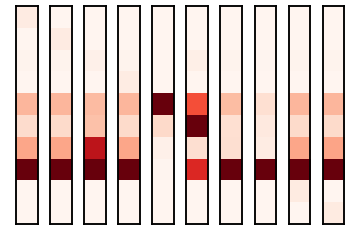

In [49]:
visualize_change(diffs[1])

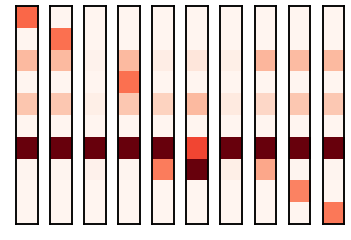

In [51]:
visualize_change(diffs[3])

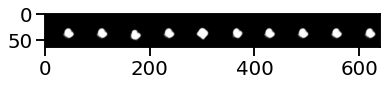

In [69]:
import torchvision.utils as vutils

recons_side_by_side = torch.cat(diffs[0][3].chunk(10, dim=0), dim = 3)
img_input_vs_recon = vutils.make_grid(recons_side_by_side, normalize=True, value_range=(0.0,1.0)).permute(1,2,0).cpu()

fig, axs = plt.subplots()
axs.imshow(img_input_vs_recon)

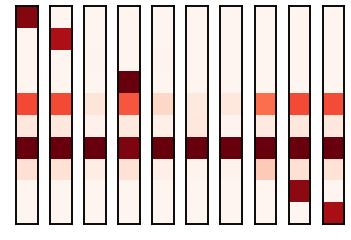

In [70]:
visualize_change(diffs[30])

# Correlation 0.2 Beta 1

In [6]:
current_device = torch.device("cuda:3")
batch_size = 64
seed = 123
beta = 1.0
z_dim = 10

checkpoint_path="../train-logs/jscmodel_bvae_w1corr02_dsprites/epoch=25-step=299520.ckpt"

acts_for_dsprites_full, dsprites_full_dataset, model_dsprites_full  = load_model_and_data_and_get_activations(
                    dset_name='dsprites_full', dset_path='../datasets', 
                    batch_size=batch_size, z_dim=z_dim , beta=beta, 
                    checkpoint_path=checkpoint_path, current_device=current_device, 
                    activation_with_label=False, seed=123,  batches=10, l_zero_reg=False
    )

dsprites_full_loader = DataLoader(dsprites_full_dataset, batch_size=batch_size, shuffle = False,drop_last=True)
img, labels = next(dsprites_full_loader.__iter__())



Experiment class: cpu
Model class: cpu
Loaded 737280 images


  0%|▏                                                                                                                                                                                                   | 10/10368 [00:00<16:03, 10.75it/s]


In [7]:
diffs = check_correlated_dimensions(img.to(current_device), model_dsprites_full, current_device)

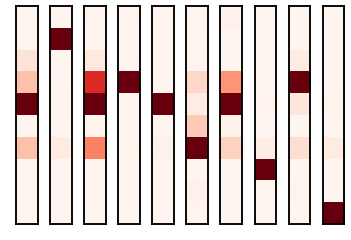

In [10]:
visualize_change(diffs[0])

In [11]:
#plt.imshow(diffs[0][0].cpu().numpy().T, cmap='Reds')

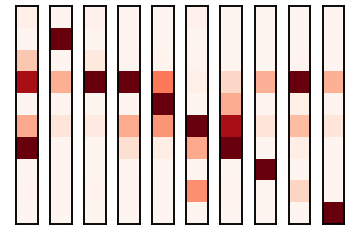

In [77]:
visualize_change(diffs[1])

In [12]:
#plt.imshow(diffs[1][0].cpu().numpy().T, cmap='Reds')

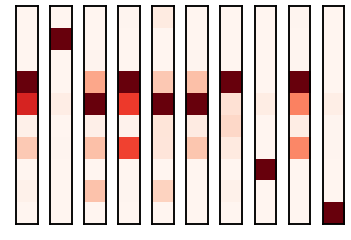

In [79]:
visualize_change(diffs[2])

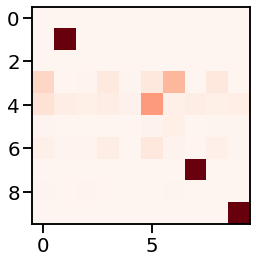

In [80]:
plt.imshow(diffs[2][0].cpu().numpy().T, cmap='Reds')

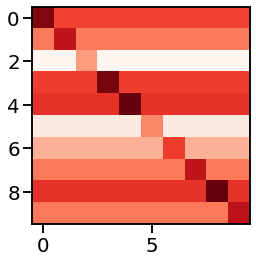

In [81]:
plt.imshow(diffs[2][2].cpu().numpy().T, cmap='Reds')

# 50 epochs dsprites 0.2 corr beta=1

In [4]:
current_device = torch.device("cuda:0")
dataset='dsprites_correlated'
checkpoint_path="../models/epoch=49-step=576000.ckpt"
os.environ['DISENTANGLEMENT_LIB_DATA'] = '../datasets'

model, activations, data_loader  = model_and_activations(current_device,  dataset, checkpoint_path, l_dim=5, num_batches=150,
                                                        activation_type='for_scatter')

Experiment class: cpu
Model class: cpu
Initialize [CorrelatedDSpritesDataset] with 737280 examples. Shape (737280, 64, 64).


In [74]:
mus, labels = activations

In [75]:
len(mus), len(labels), type(model)

(9600, 9600, bvae_experiment.BVAEExperiment)

In [8]:
from sklearn.ensemble import GradientBoostingClassifier

mus, labels = activations
gbt_models = {}
feature_imps = []
train_acc = []
test_acc = []
factors = ["shape", "scale", "orientation", "position x", "position y"]
N = len(mus)
T = N - 1000 # 100 points for test

for current_factor in range(len(factors)):
    
    X_train, X_test = mus[:T, :], mus[T:, :] 
    y_train, y_test = labels[:T, current_factor], labels[T:, current_factor]

    gbt_models[factors[current_factor]] = GradientBoostingClassifier().fit(X_train, y_train)

    feature_imps.append(gbt_models[factors[current_factor]].feature_importances_.reshape(1, X_train.shape[1]))
    
    train_acc.append(np.mean(gbt_models[factors[current_factor]].predict(X_train) == y_train))
    test_acc.append(np.mean(gbt_models[factors[current_factor]].predict(X_test) == y_test))

([<matplotlib.axis.XTick at 0x26baaa07130>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9')])

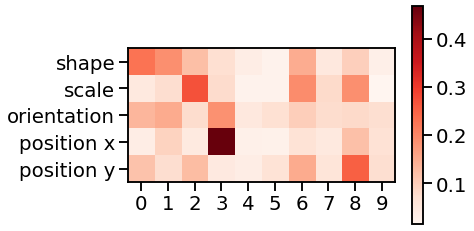

In [60]:
feature_imps_cat =np.concatenate(feature_imps, axis=0)
plt.imshow(feature_imps_cat, cmap='Reds')
plt.colorbar()
plt.yticks(ticks=range(len(factors)), labels=factors)
plt.xticks(ticks=range(10), labels=range(10))

In [70]:
feature_imps_cat

array([[0.2283, 0.1901, 0.1224, 0.071 , 0.0359, 0.0237, 0.1487, 0.0502,
        0.0987, 0.0312],
       [0.0477, 0.0749, 0.2709, 0.0791, 0.0244, 0.0245, 0.193 , 0.0798,
        0.1896, 0.016 ],
       [0.1353, 0.1512, 0.076 , 0.1853, 0.0507, 0.0697, 0.0997, 0.0767,
        0.0815, 0.074 ],
       [0.0361, 0.0925, 0.0455, 0.4671, 0.0298, 0.0268, 0.0653, 0.0491,
        0.1215, 0.0662],
       [0.1166, 0.0753, 0.1255, 0.0467, 0.0367, 0.0642, 0.1511, 0.0585,
        0.2528, 0.0726]])

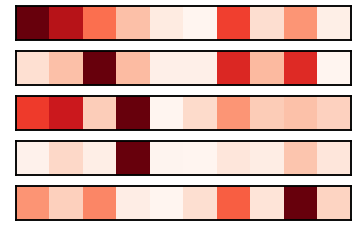

In [58]:
fig, ax = plt.subplots(5,1)
for i in range(5):
    ax[i].imshow(feature_imps_cat[i].reshape(1,10), cmap='Reds')
    ax[i].set_yticks([])
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].set_xticks([])

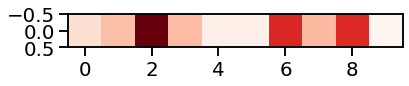

In [43]:
plt.imshow(feature_imps_cat[1].reshape(1,10), cmap='Reds')

In [10]:
train_acc, test_acc

([0.8140697674418604,
  0.6846511627906977,
  0.8198837209302325,
  0.8526744186046512,
  0.8348837209302326],
 [0.754, 0.516, 0.268, 0.404, 0.31])

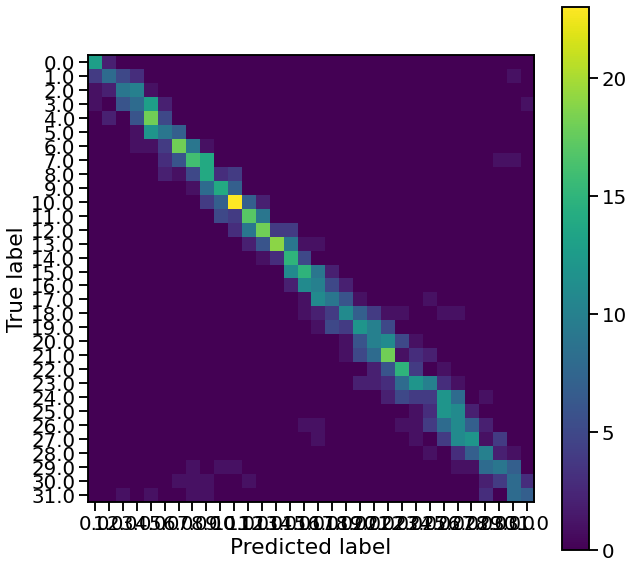

In [76]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(gbt_models['position x'], mus[T:, :], labels[T:, 3], ax=ax, include_values=False)

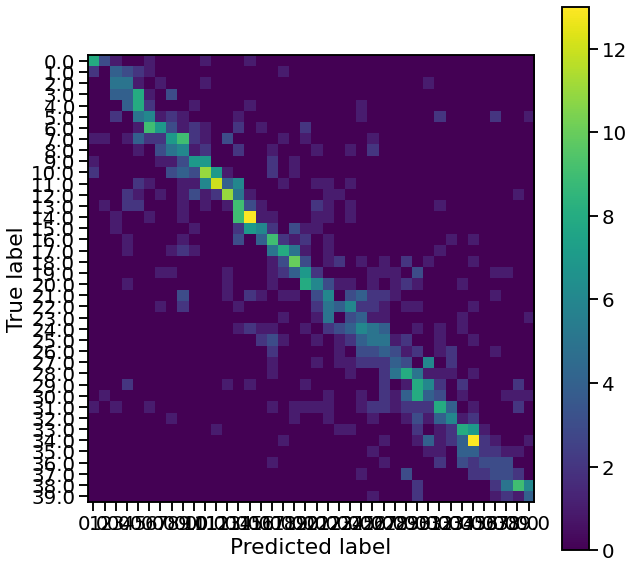

In [77]:
fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(gbt_models['orientation'], mus[T:, :], labels[T:, 2], ax=ax, include_values=False)

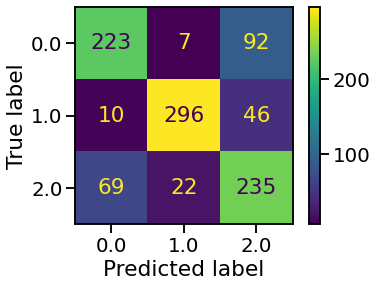

In [14]:
plot_confusion_matrix(gbt_models['shape'], mus[T:, :], labels[T:, 0])

In [9]:
def pairwise_dimension_sactter_plot(mus, labels, xdim, ydim, ldim):
    label_names = ["shape", "scale", "orientation", "position x", "position y"]
    sc = plt.scatter(mus[:, xdim], mus[:, ydim], cmap='YlGn', c=labels[:,ldim], s=5) #, norm=CenteredNorm(), s=3)
    plt.colorbar(sc)
    plt.xlabel(f"z_{xdim}")
    plt.ylabel(f"z_{ydim}")
    plt.title(f'Pairwise wrt {label_names[ldim]}')

In [24]:
#pairwise_dimension_sactter_plot(mus, labels, 1, 3, 2)


In [25]:
#pairwise_dimension_sactter_plot(mus, labels, 1, 3, 3)

In [ ]:
img, labels = next(data_loader.__iter__())

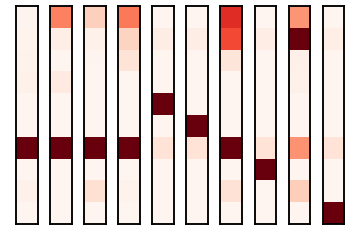

In [63]:
diffs = check_correlated_dimensions(img.to(current_device), model, current_device, perturb_value=0.75, perturb_mode='fixed')
visualize_perturbed_dims(diffs[0])

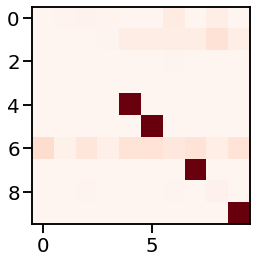

In [64]:
plt.imshow(diffs[0][0].cpu().numpy().T, cmap='Reds')

In [65]:
diffs[0][0]

tensor([[4.5182e-04, 1.1423e-03, 1.3873e-03, 1.8727e-03, 2.4626e-06, 2.1884e-06,
         7.5777e-02, 3.5864e-06, 1.5851e-03, 2.5356e-07],
        [6.3421e-03, 6.1926e-04, 4.0235e-05, 9.8195e-04, 2.4181e-06, 6.8726e-07,
         1.4879e-02, 9.8540e-08, 2.1720e-06, 7.3373e-06],
        [9.0307e-03, 1.2664e-03, 2.9169e-04, 2.7575e-07, 4.2188e-06, 1.9430e-07,
         5.0438e-02, 4.4566e-06, 6.0606e-03, 5.5956e-07],
        [7.6600e-03, 2.7948e-03, 1.7236e-03, 6.1130e-05, 7.9607e-06, 1.3011e-05,
         1.6785e-02, 2.1462e-07, 2.7537e-04, 3.9356e-05],
        [3.3475e-04, 2.5731e-02, 1.1652e-03, 1.0016e-03, 5.6172e-01, 1.3058e-07,
         5.9498e-02, 1.1397e-06, 7.0406e-04, 1.9384e-06],
        [4.4050e-04, 2.7468e-02, 1.1229e-03, 1.0538e-03, 2.6916e-07, 5.6299e-01,
         5.9733e-02, 1.1236e-06, 6.4573e-04, 1.9296e-06],
        [3.0786e-02, 2.6671e-02, 4.2208e-03, 5.6959e-05, 2.2823e-06, 1.1681e-05,
         4.5398e-02, 3.0931e-07, 5.0254e-03, 7.2840e-07],
        [3.1220e-04, 2.5008

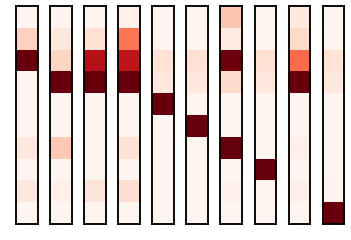

In [66]:
visualize_perturbed_dims(diffs[1])

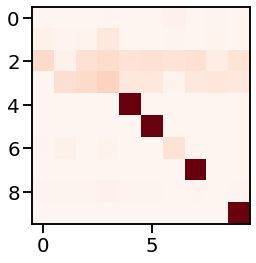

In [67]:
plt.imshow(diffs[1][0].cpu().numpy().T, cmap='Reds')

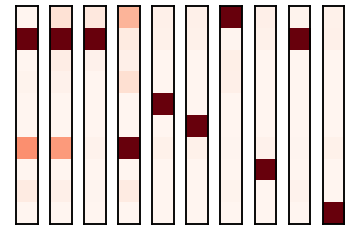

In [68]:
visualize_perturbed_dims(diffs[10])

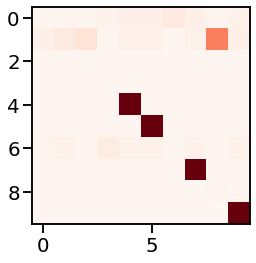

In [69]:
plt.imshow(diffs[10][0].cpu().numpy().T, cmap='Reds')